# Model training

In this section the treated data will be fitted to be inputs, the model will be structured and trained.

## Data Transform

Load the data from the stored JSON file.

In [45]:
from sklearn.preprocessing import MinMaxScaler
from joblib import dump
import pandas as pd
import numpy as np
import json

with open(".\\data\\treated_data.json") as f:
    data_dict = json.load(f)
    for song_name, song_data in data_dict.items():
        data_dict.update({song_name: pd.read_json(song_data)})

key = list(data_dict.keys())[0]
print(f"{key}\n{data_dict[key]}")

160_EIGHTMEASURE_EXERCISES_NO_1
         start        end  pitch  duration  time_to_next
0     0.000000   0.136364     76  0.136364      0.000000
1     0.000000   0.545455     60  0.545455      0.000000
2     0.000000   0.545455     67  0.545455      0.136364
3     0.136364   0.272727     79  0.136364      0.136364
4     0.272727   0.409091     77  0.136364      0.136364
..         ...        ...    ...       ...           ...
147  15.818182  15.954545     72  0.136364      0.136364
148  15.954545  16.090909     76  0.136364      0.136364
149  16.090909  16.227273     79  0.136364      0.136364
150  16.227273  16.363636     84  0.136364      0.136364
151  16.363636  16.636364     72  0.272727      0.000000

[152 rows x 5 columns]


Previous metrics to compare.

In [2]:
note_duration = pd.Series(dtype="float64")
time_to_next = pd.Series(dtype="float64")
duration = pd.Series(dtype="float64")
for song in data_dict.values():
    time_to_next = pd.concat([time_to_next, song['time_to_next']])
    note_duration = pd.concat([note_duration, song['duration']])
    pitch = pd.concat([pitch, song['pitch']])

In an attempt to make the attributes more symetric, a base 2 log was applied to the "duration" attribute, and a base 100 log was applied to the "time_to_next" attribute.

In [3]:
for song in data_dict.values():
    song.loc[:, 'duration'] = np.log2(song.duration)
    song.loc[:, 'time_to_next'] = np.log(song.time_to_next + 1)/np.log(100) ## needed to add 1 to avoid 0 value for the log

note_duration2 = pd.Series(dtype="float64")
time_to_next2 = pd.Series(dtype="float64")
for song in data_dict.values():
    time_to_next2 = pd.concat([time_to_next2, song['time_to_next']])
    note_duration2 = pd.concat([note_duration2, song['duration']])

print(f"Duration:\n{note_duration2.describe()}")
print(f"Time to Next:\n{time_to_next2.describe()}")

Duration:
count    789917.000000
mean         -1.731872
std           1.086461
min          -3.923379
25%          -2.552541
50%          -2.000000
75%          -1.000000
max           2.807355
dtype: float64
Time to Next:
count    789917.000000
mean          0.023792
std           0.033267
min           0.000000
25%           0.000000
50%           0.000000
75%           0.041229
max           0.480549
dtype: float64


Normalize values between 0 and 1.

In [4]:
duration_scaler = MinMaxScaler()
time_to_next_scaler = MinMaxScaler()

duration_sc = MinMaxScaler().fit_transform(np.array(note_duration[:]).reshape(-1,1)).flatten()
duration2_sc = duration_scaler.fit_transform(np.array(note_duration2[:]).reshape(-1,1)).flatten()

time_to_next_sc = MinMaxScaler().fit_transform(np.array(time_to_next[:]).reshape(-1,1)).flatten()
time_to_next2_sc = time_to_next_scaler.fit_transform(np.array(time_to_next2[:]).reshape(-1,1)).flatten()

Comparison between original and log'd values.

<AxesSubplot:>

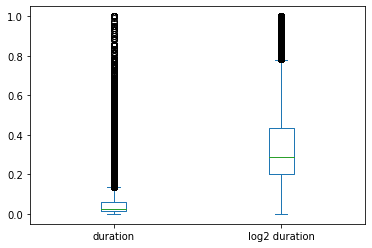

In [5]:
pd.DataFrame({'duration': duration_sc.flatten(), 'log2 duration': duration2_sc.flatten()}).plot.box()

<AxesSubplot:>

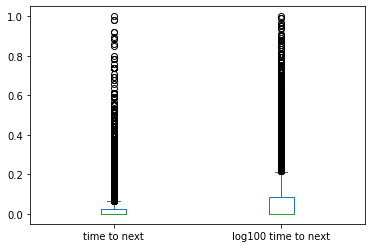

In [6]:
pd.DataFrame({'time to next': time_to_next_sc, 'log100 time to next': time_to_next2_sc}).plot.box()

The pitch values are pretty symetric, so they can be just normalized from 0 to 1.

In [7]:
pitch_scaler = MinMaxScaler()

pitch_sc = pitch_scaler.fit_transform(np.array(pitch[:]).reshape(-1,1)).flatten()

In [46]:
## storing the scalers

dump(pitch_scaler, ".\\data\\pitch_scaler.save")
dump(duration_scaler, ".\\data\\duration_scaler.save")
dump(time_to_next_scaler, ".\\data\\time_to_next_scaler.save")

['.\\data\\time_to_next_scaler.save']

## Creating input arrays

Using 10 notes to predict the next one.
Separation of training inputs as 90% of data, and 10% for validation.

In [8]:
data = list(zip(pitch_sc, duration2_sc, time_to_next2_sc))

samples = 10
predict = 1
X_train, X_test = [], []
Y_train, Y_test = [], []
train_pct = 0.9

notes_cnt = 0
for song in data_dict.values():
    test_tresh = round(train_pct * song.shape[0])
    for i in range(song.shape[0] - samples):
        if i < test_tresh:
            X_train.append(data[notes_cnt+i:notes_cnt+i+samples])
            Y_train.append(data[notes_cnt+i+samples])
        else:
            X_test.append(data[notes_cnt+i:notes_cnt+i+samples])
            Y_test.append(data[notes_cnt+i+samples])
    notes_cnt += song.shape[0]

In [9]:
X_train, X_test = np.array(X_train), np.array(X_test)
Y_train, Y_test = np.array(Y_train), np.array(Y_test)

print(f"Shape of X:\nTrain: {X_train.shape}\tTest: {X_test.shape}")
print(f"Shape of Y:\nTrain: {Y_train.shape}\tTest: {Y_test.shape}")

Shape of X:
Train: (710876, 10, 3)	Test: (71871, 10, 3)
Shape of Y:
Train: (710876, 3)	Test: (71871, 3)


## Model Structure and Training

Two approches were thought for the RNN model: one using one model to try to generate all three of the note attributes; and a second using three separate models, each one to predict a different attribute.

Both models are built using GRU cells due to their ability of long term memory.

In [10]:
from keras import layers, Sequential, callbacks
import matplotlib.pyplot as plt

### Single Model Approach

#### Model Structure

This model will be a Sequential keras model with the following layers:

* GRU layer (30 units)
* Dropout of 20%
* Dense layer with 3 outputs (for the three note attributes)

In [11]:
model = Sequential()

model.add(layers.GRU(
    30,
    activation = "tanh",
    recurrent_activation = "sigmoid",
    input_shape = (X_train.shape[1], X_train.shape[2])
))

model.add(layers.Dropout(rate=0.2))

model.add(layers.Dense(3))

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30)                3150      
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 3)                 93        
                                                                 
Total params: 3,243
Trainable params: 3,243
Non-trainable params: 0
_________________________________________________________________


#### Model Training

In [12]:
history = model.fit(
    X_train,
    Y_train,
    shuffle=False,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        callbacks.ModelCheckpoint(
            filepath = ".\\temp\\single_model_checkpoint.h5",
            save_best_only = True,
        )
    ],
    verbose=1
)

Epoch 1/100
17772/17772 [==============================] - 53s 3ms/step - loss: 0.0103 - val_loss: 0.0092
Epoch 2/100
17772/17772 [==============================] - 52s 3ms/step - loss: 0.0088 - val_loss: 0.0082
Epoch 3/100
17772/17772 [==============================] - 52s 3ms/step - loss: 0.0081 - val_loss: 0.0076
Epoch 4/100
17772/17772 [==============================] - 46s 3ms/step - loss: 0.0077 - val_loss: 0.0074
Epoch 5/100
17772/17772 [==============================] - 44s 2ms/step - loss: 0.0075 - val_loss: 0.0073
Epoch 6/100
17772/17772 [==============================] - 44s 2ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 7/100
17772/17772 [==============================] - 44s 2ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 8/100
17772/17772 [==============================] - 44s 2ms/step - loss: 0.0072 - val_loss: 0.0070
Epoch 9/100
17772/17772 [==============================] - 44s 2ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 10/100
17772/17772 [====================

#### Model Review

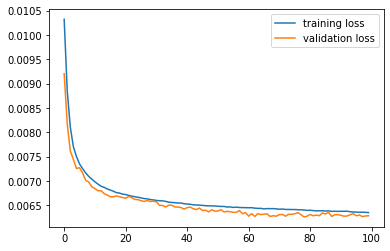

In [13]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label ='validation loss')
plt.legend()

2246/2246 [==============================] - 2s 823us/step


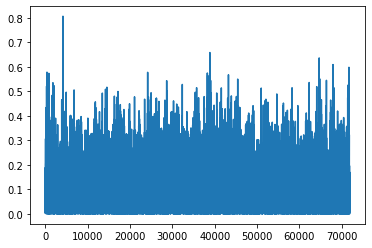

In [39]:
y_pred = model.predict(X_test)
error = np.sqrt((Y_test - y_pred) ** 2)

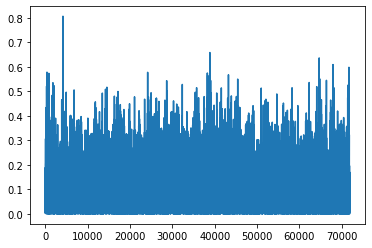

In [42]:
plt.plot(error[:,0])

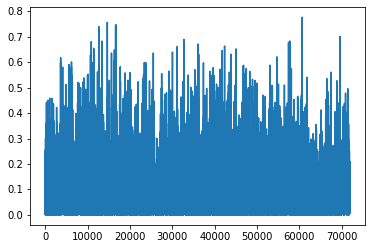

In [40]:
plt.plot(error[:,1])

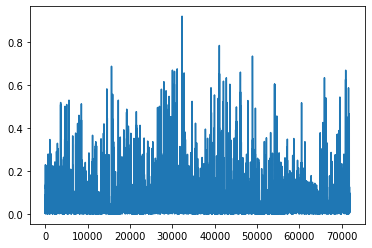

In [41]:
plt.plot(error[:,2])

### Separate Models Approach

#### Models Structure

This approach will consist of three models, each will be a Sequential keras model with the following layers:

* GRU layer (15 units)
* Dropout of 20%
* Dense layer with 1 outputs

In [48]:
model_pitch = Sequential(name="Pitch_Model")

model_pitch.add(layers.GRU(
    10,
    activation = "tanh",
    recurrent_activation = "sigmoid",
    input_shape = (X_train.shape[1], X_train.shape[2])
))

model_pitch.add(layers.Dropout(rate=0.2))

model_pitch.add(layers.Dense(1))

model_pitch.compile(loss='mean_squared_error', optimizer='adam')

model_pitch.summary()

Model: "Pitch_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_9 (GRU)                 (None, 10)                450       
                                                                 
 dropout_9 (Dropout)         (None, 10)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 11        
                                                                 
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________


In [25]:
model_duration = Sequential(name="Duration_Model")

model_duration.add(layers.GRU(
    15,
    activation = "tanh",
    recurrent_activation = "sigmoid",
    input_shape = (X_train.shape[1], X_train.shape[2])
))

model_duration.add(layers.Dropout(rate=0.2))

model_duration.add(layers.Dense(1))

model_duration.compile(loss='mean_squared_error', optimizer='adam')

model_duration.summary()

Model: "Duration_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 15)                900       
                                                                 
 dropout_6 (Dropout)         (None, 15)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 16        
                                                                 
Total params: 916
Trainable params: 916
Non-trainable params: 0
_________________________________________________________________


In [26]:
model_time2next = Sequential(name="Time_to_Next_Model")

model_time2next.add(layers.GRU(
    15,
    activation = "tanh",
    recurrent_activation = "sigmoid",
    input_shape = (X_train.shape[1], X_train.shape[2])
))

model_time2next.add(layers.Dropout(rate=0.2))

model_time2next.add(layers.Dense(1))

model_time2next.compile(loss='mean_squared_error', optimizer='adam')

model_time2next.summary()

Model: "Time_to_Next_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_7 (GRU)                 (None, 15)                900       
                                                                 
 dropout_7 (Dropout)         (None, 15)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 16        
                                                                 
Total params: 916
Trainable params: 916
Non-trainable params: 0
_________________________________________________________________


#### Model Training

In [44]:
history_pitch = model_pitch.fit(
    X_train,
    Y_train[:, 0],
    shuffle=False,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        callbacks.ModelCheckpoint(
            filepath = ".\\temp\\pitch_model_checkpoint.h5",
            save_best_only = True,
        )
    ],
    verbose=1
)

Epoch 1/100
17772/17772 [==============================] - 49s 3ms/step - loss: 0.0162 - val_loss: 0.0158
Epoch 2/100
17772/17772 [==============================] - 47s 3ms/step - loss: 0.0134 - val_loss: 0.0151
Epoch 3/100
17772/17772 [==============================] - 48s 3ms/step - loss: 0.0123 - val_loss: 0.0139
Epoch 4/100
17772/17772 [==============================] - 48s 3ms/step - loss: 0.0117 - val_loss: 0.0133
Epoch 5/100
17772/17772 [==============================] - 48s 3ms/step - loss: 0.0112 - val_loss: 0.0130
Epoch 6/100
17772/17772 [==============================] - 48s 3ms/step - loss: 0.0109 - val_loss: 0.0124
Epoch 7/100
17772/17772 [==============================] - 48s 3ms/step - loss: 0.0107 - val_loss: 0.0120
Epoch 8/100
17772/17772 [==============================] - 48s 3ms/step - loss: 0.0105 - val_loss: 0.0119
Epoch 9/100
17772/17772 [==============================] - 48s 3ms/step - loss: 0.0103 - val_loss: 0.0118
Epoch 10/100
17772/17772 [====================

#### Model Review

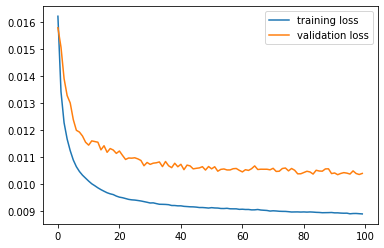

In [47]:
plt.plot(history_pitch.history['loss'], label = 'training loss')
plt.plot(history_pitch.history['val_loss'], label ='validation loss')
plt.legend()